<a href="https://colab.research.google.com/github/abhisheksambyal/Class-Activation-Maps/blob/master/Grad_CAM_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Grad-CAM

---
In this section we will work with dog breeds classification. The dataset can be downloaded from Kaggle at (https://www.kaggle.com/samcrochet/p29crosspuredogs). There are 15 breeds of dogs in this dataset. Train, Validation and Test split as provided in the dataset can be used.

## To do

---
1. Download the pretrained model (VGG, ResNet, DenseNet, etc.) from the Keras or TorchVision library.
2. Modify the final fully connected layer to accomodate 15 classes.
3. Finetune the model to classify the given dataset of 15 dog breeds.
4. Use the validation set to get the optimal hyperparameters so as to achieve high validation accuracy. In case you are adopting any other strategies like Data Augmentation to increase the accuracy, kindly mention the same in the jupyter notebook.
5. Now use the test set to assess the generalization ability of the fine tuned model. Report the accuracy of the trained CNN on the test set.
6. You may refer to the Research Paper by Selvaraju et al.[5] for a technique to explain the working of a CNN by visualizing the region of the image that the CNN is looking at, in order to make the prediction.
7. Implement the Grad-CAM methodolgy by Selvaraju et al.[5] to visualize which regions of the test image is seminal to the classifier's output.



---
**Reference:**

[5]. Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna
Vedantam, Devi Parikh, Dhruv Batra; Grad-CAM: Visual Explanations From
Deep Networks via Gradient-Based Localization, The IEEE International
Conference on Computer Vision (ICCV), 2017, pp. 618-626.

In [ ]:
%load_ext lab_black

In [ ]:
import torchvision
from torchvision import models, datasets, transforms

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import cv2

import time
from tqdm import tqdm_notebook
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Hyperparameters
args = {
    "model_name": "vgg19",
    "trainpath": "P29-Cross-Pure-Dogs/train",
    "valpath": "P29-Cross-Pure-Dogs/val",
    "testpath": "P29-Cross-Pure-Dogs/test",
    "batchsize": 32,
    "testbatchsize": 1,
    "lr": 1e-2,
    "num_epochs": 20,
    "global_trn_loss": [],
    "global_val_loss": [],
    "global_test_loss": [],
    "train_running_loss": [],
    "val_running_loss": [],
    "test_running_loss": [],
    "global_val_acc": [],
    "global_trn_acc": [],
    "global_test_acc": [],
}


class dotdict(dict):
    def __getattr__(self, name):
        return self[name]


config = dotdict(args)

In [ ]:
####################################
# DOWNLOADING THE PRETRAINED MODELS USING TORCHVISION

# MODIFYING THE FULLY-CONNECTED LAYERS FOR OUR PROBLEM(15 DOG CLASSES)
######################################################################

if config.model_name == "vgg19":
    model = models.vgg19(pretrained=True)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=15)

elif config.model_name == "resnet50":
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(in_features=2048, out_features=15)

elif config.model_name == "resnext50":
    model = models.resnext50_32x4d(pretrained=True)
    model.fc = nn.Linear(in_features=2048, out_features=15)

elif config.model_name == "resnext101":
    model = models.resnext101_32x8d(pretrained=True)
    model.fc = nn.Linear(in_features=2048, out_features=15)

elif config.model_name == "densenet161":
    model = models.resnext50_32x4d(pretrained=True)
    model.classifier = nn.Linear(in_features=2208, out_features=15)

model = model.to(device)

## Data augmentation

Three hyperparameters have to be optimized i.e., batch_size, learning rate, and number of epochs. I am using early stopping to get the best model having the best validation accuracy, so no need to optimize # of epochs. For batch size and learning rate, I manually tried their variations and found out their optimal value.
I have also used some data augmentation techniques like **horizontal filp, random rotation** of the images to improve robustness and accuracy of the model.  
Hyperparameter search for only two parameters seems quite taxing and insignificant. Therefore, I am not using grid search, random search, etc. in this scenario.

In [ ]:
####################################
# USING VARIOUS DATA AUGMENTATION TECHNIQUES ARE USED HERE TO IMPROVE THE ACCURACY OF THE MODEL
####################################

trn_tfms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(-30, 30)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

tfms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

grad_tfms = transforms.Compose(
    [
        transforms.Resize(230),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# Dataset class
traindataset = datasets.ImageFolder(config.trainpath, transform=trn_tfms)
trainloader = DataLoader(traindataset, config.batchsize, shuffle=True, num_workers=2)

valdataset = datasets.ImageFolder(config.valpath, transform=tfms)
valloader = DataLoader(valdataset, config.batchsize, shuffle=False, num_workers=2)

testdataset = datasets.ImageFolder(config.testpath, transform=tfms)
testloader = DataLoader(testdataset, config.batchsize, shuffle=False)

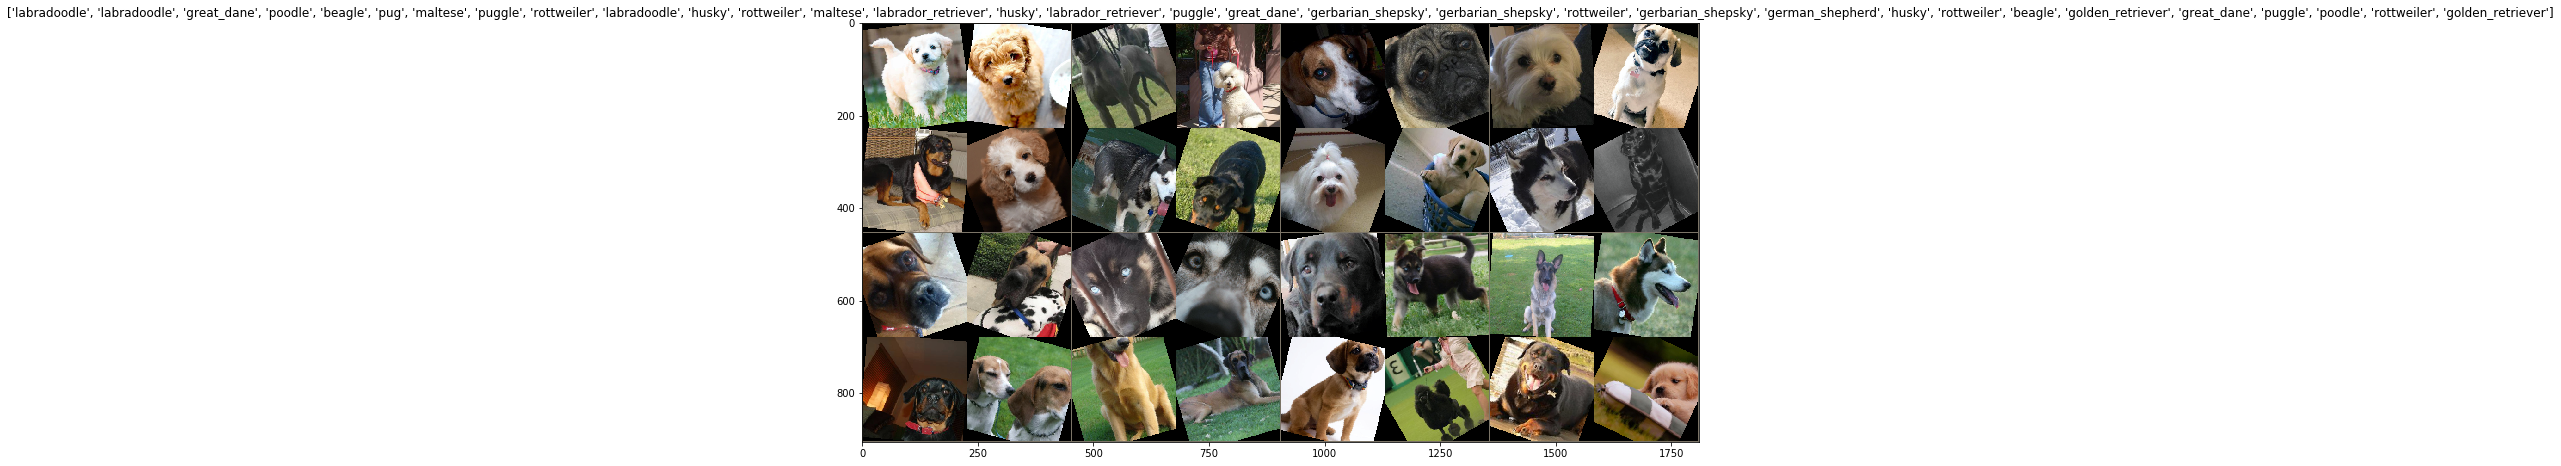

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=(15, 15))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[traindataset.classes[x] for x in classes])

In [ ]:
print("Mapping of index to class labels")

for l, name in enumerate(traindataset.classes):
    print(l, name)

Mapping of index to class labels
0 beagle
1 gerbarian_shepsky
2 german_shepherd
3 golden_doodle
4 golden_retriever
5 great_dane
6 husky
7 labradoodle
8 labrador_retriever
9 maltese
10 maltipoo
11 poodle
12 pug
13 puggle
14 rottweiler


In [ ]:
####################################
# FINETUNING THE MODEL'S LAST FC LAYER WEIGHTS WHICH WE APPENDED EARLIER
####################################

if config.model_name == "vgg19":
    optimizer = optim.SGD(model.classifier[6].parameters(), lr=config.lr)

elif config.model_name == "resnet50":
    optimizer = optim.SGD(model.fc.parameters(), lr=config.lr)

elif config.model_name == "resnext50":
    optimizer = optim.SGD(model.fc.parameters(), lr=config.lr)

elif config.model_name == "resnext101":
    optimizer = optim.SGD(model.fc.parameters(), lr=config.lr)

elif config.model_name == "densenet161":
    optimizer = optim.SGD(model.classifier.parameters(), lr=config.lr)

In [ ]:
criterion = nn.CrossEntropyLoss()


def train(args, model, device, trainloader, optimizer):
    # Switch model to training mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
    correct = 0
    total = 0
    model.train()
    for idx, (images, target) in enumerate(trainloader):
        images, labels = images.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        args.train_running_loss.append(loss.item())

        # Finding accuracy of the whole trainloader dataset
        total += labels.size(0)
        correct += torch.sum(torch.eq(torch.max(output, dim=1)[1], labels)).item()

        loss.backward()
        optimizer.step()

    args.global_trn_loss.append(
        sum(args.train_running_loss) / len(args.train_running_loss)
    )
    args.global_trn_acc.append(100 * correct / total)


def validate(args, model, device, valloader):
    # Switch model to evaluation mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for vdx, (images, target) in enumerate(valloader):
            vinputs, vlabels = images.to(device), target.to(device)
            outputs = model(vinputs)
            valloss = criterion(outputs, vlabels)
            args.val_running_loss.append(valloss.item())

            # Finding accuracy of the whole valloader dataset
            total += vlabels.size(0)
            correct += torch.sum(torch.eq(torch.max(outputs, dim=1)[1], vlabels)).item()

    args.global_val_loss.append(sum(args.val_running_loss) / len(args.val_running_loss))
    args.global_val_acc.append(100 * correct / total)


def test(args, model, device, loader):
    # Switch model to evaluation mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for vdx, (images, target) in enumerate(loader):
            vinputs, vlabels = images.to(device), target.to(device)
            outputs = model(vinputs)
            testloss = criterion(outputs, vlabels)
            args.test_running_loss.append(testloss.item())

            # Finding accuracy of the whole testloader dataset
            total += vlabels.size(0)
            correct += torch.sum(torch.eq(torch.max(outputs, dim=1)[1], vlabels)).item()

    args.global_test_loss.append(
        sum(args.test_running_loss) / len(args.test_running_loss)
    )
    args.global_test_acc.append(100 * correct / total)


def main(epochs):
    previous_val_acc = -1
    MODEL_SAVE_PATH = f"./saved_models/{config.model_name}_graph.pth"
    #     MODEL_GRAPH = f'./saved_models/{config.model_name}_graph.pth'

    for epoch in range(epochs):
        start_time = time.time()
        train(config, model, device, trainloader, optimizer)
        validate(config, model, device, valloader)
        test(config, model, device, testloader)
        #         s = 'Epoch [{}/{}], TRN Loss:{:.4f}, VAL Loss:{:.4f}, TrnDiceScr:{:.4f}, ValDiceScr:{:.4f}, Time {:.2f}'
        s = "Epoch [{}/{}], TRN Loss:{:.4f}, VAL Loss:{:.4f}, TEST Loss:{:.4f}, TrnAcc:{:.4f}, ValAcc:{:.4f}, TestAcc:{:.4f}, Time {:.2f}"
        print(
            s.format(
                epoch + 1,
                config.num_epochs,
                config.global_trn_loss[-1],
                config.global_val_loss[-1],
                config.global_test_loss[-1],
                config.global_trn_acc[-1],
                config.global_val_acc[-1],
                config.global_test_acc[-1],
                (time.time() - start_time) / 60,
            )
        )

        # Save all the losses
        #         if epoch % 10 == 0:
        #             torch.save({
        #                 'global_trn_loss':config.global_trn_loss,
        #                 'global_val_loss':config.global_val_loss,
        #                 'global_test_loss':config.global_test_loss,
        #                 'global_trn_acc': config.global_trn_acc,
        #                 'global_val_acc': config.global_val_acc,
        #                 'global_test_acc': config.global_test_acc,
        #             }, MODEL_GRAPH)
        #             print(f'Saved losses to {MODEL_GRAPH} at epoch:{epoch}')

        # Save the model with minimim validation loss
        if config.global_val_acc[-1] > previous_val_acc:
            print("========================")
            print(
                "Val accuracy increased from {} to {}".format(
                    previous_val_acc, config.global_val_acc[-1]
                )
            )
            print("Saving model to " + MODEL_SAVE_PATH)
            previous_val_acc = config.global_val_acc[-1]
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "global_trn_loss": config.global_trn_loss,
                    "global_val_loss": config.global_val_loss,
                    "global_test_loss": config.global_test_loss,
                    "global_trn_acc": config.global_trn_acc,
                    "global_val_acc": config.global_val_acc,
                    "global_test_acc": config.global_test_acc,
                },
                MODEL_SAVE_PATH,
            )


#             print('========================')

main(config.num_epochs)

Epoch [1/20], TRN Loss:1.1433, VAL Loss:0.7101, TEST Loss:0.8169, TrnAcc:67.2749, ValAcc:79.7101, TestAcc:77.7778, Time 0.43
Val accuracy increased from -1 to 79.71014492753623
Saving model to ./saved_models/vgg19_graph.pth
Epoch [2/20], TRN Loss:0.8814, VAL Loss:0.6062, TEST Loss:0.6909, TrnAcc:81.1065, ValAcc:81.1594, TestAcc:80.9524, Time 0.43
Val accuracy increased from 79.71014492753623 to 81.15942028985508
Saving model to ./saved_models/vgg19_graph.pth
Epoch [3/20], TRN Loss:0.7685, VAL Loss:0.5178, TEST Loss:0.5993, TrnAcc:81.8128, ValAcc:87.5776, TestAcc:85.7143, Time 0.43
Val accuracy increased from 81.15942028985508 to 87.5776397515528
Saving model to ./saved_models/vgg19_graph.pth
Epoch [4/20], TRN Loss:0.6949, VAL Loss:0.4688, TEST Loss:0.5480, TrnAcc:84.2849, ValAcc:87.7847, TestAcc:86.1111, Time 0.43
Val accuracy increased from 87.5776397515528 to 87.78467908902691
Saving model to ./saved_models/vgg19_graph.pth
Epoch [5/20], TRN Loss:0.6449, VAL Loss:0.4471, TEST Loss:0.5

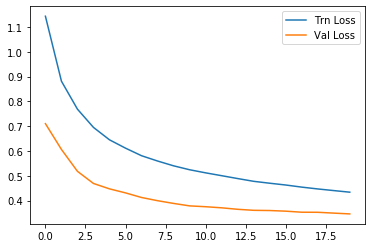

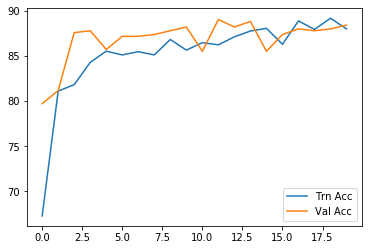

In [ ]:
plt.plot(range(len(config.global_trn_loss)), config.global_trn_loss, label="Trn Loss")
plt.plot(range(len(config.global_val_loss)), config.global_val_loss, label="Val Loss")
plt.legend()
plt.show()
plt.plot(range(len(config.global_trn_acc)), config.global_trn_acc, label="Trn Acc")
plt.plot(range(len(config.global_val_acc)), config.global_val_acc, label="Val Acc")
plt.legend()
plt.show()

Epoch [1/20], TRN Loss:0.4281, VAL Loss:0.3431, TEST Loss:0.4383, TrnAcc:88.6404, ValAcc:88.6128, TestAcc:85.7143, Time 0.41
Val accuracy increased from -1 to 88.6128364389234
Saving model to ./saved_models/vgg19_graph.pth
Epoch [2/20], TRN Loss:0.4224, VAL Loss:0.3405, TEST Loss:0.4360, TrnAcc:88.9935, ValAcc:88.6128, TestAcc:86.5079, Time 0.41
Epoch [3/20], TRN Loss:0.4166, VAL Loss:0.3381, TEST Loss:0.4340, TrnAcc:88.6992, ValAcc:88.6128, TestAcc:86.9048, Time 0.41
Epoch [4/20], TRN Loss:0.4116, VAL Loss:0.3358, TEST Loss:0.4323, TrnAcc:88.4638, ValAcc:88.6128, TestAcc:86.5079, Time 0.41
Epoch [5/20], TRN Loss:0.4055, VAL Loss:0.3337, TEST Loss:0.4308, TrnAcc:90.8770, ValAcc:88.8199, TestAcc:86.9048, Time 0.41
Val accuracy increased from 88.6128364389234 to 88.81987577639751
Saving model to ./saved_models/vgg19_graph.pth
Epoch [6/20], TRN Loss:0.4001, VAL Loss:0.3319, TEST Loss:0.4296, TrnAcc:89.5821, ValAcc:88.8199, TestAcc:86.5079, Time 0.41
Epoch [7/20], TRN Loss:0.3952, VAL Loss

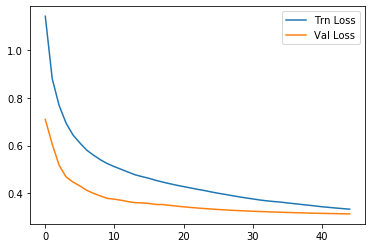

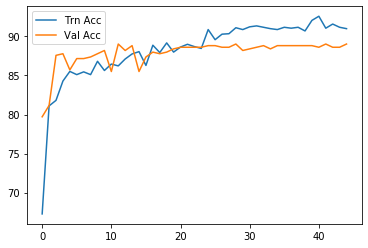

In [ ]:
####################################
# FINETUNING THE MODEL WEIGHTS (ALL)
####################################

if config.model_name == "vgg19":
    optimizer = optim.SGD(model.parameters(), lr=config.lr * 1e-2)

elif config.model_name == "resnet50":
    optimizer = optim.SGD(model.parameters(), lr=config.lr)

elif config.model_name == "resnext50":
    optimizer = optim.SGD(model.parameters(), lr=config.lr)

elif config.model_name == "resnext101":
    optimizer = optim.SGD(model.parameters(), lr=config.lr)

elif config.model_name == "densenet161":
    optimizer = optim.SGD(model.parameters(), lr=config.lr)


main(epochs=25)

plt.plot(range(len(config.global_trn_loss)), config.global_trn_loss, label="Trn Loss")
plt.plot(range(len(config.global_val_loss)), config.global_val_loss, label="Val Loss")
plt.legend()
plt.show()
plt.plot(range(len(config.global_trn_acc)), config.global_trn_acc, label="Trn Acc")
plt.plot(range(len(config.global_val_acc)), config.global_val_acc, label="Val Acc")
plt.legend()
plt.show()

## Accuracy of the trained CNN on the test set

In [ ]:
MODEL_SAVE_PATH = f"./saved_models/{config.model_name}_graph.pth"

checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

test(config, model, device, testloader)
print(f'Accuracy on the test set: {config.global_test_acc[0]:.6f}%')

Accuracy on the test set: 86.111111%


# Grad-CAM Implementation

In [ ]:
# This function converts pytorch tensor dimensions sequence to the plt.imshow compatiable dimension sequence
def change_dim(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [ ]:
grad_tfms = transforms.Compose(
    [
        transforms.Resize(230),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

testdataset = datasets.ImageFolder(config.testpath, transform=grad_tfms)
testloader = DataLoader(testdataset, config.testbatchsize, shuffle=True)

In [ ]:
class VGG_with_hook(nn.Module):
    def __init__(self):
        super(VGG_with_hook, self).__init__()

        # get model features learned in the previous section
        self.features = model.features[:36]

        # adding maxpool layer in he model as it was in the original model
        self.maxpool2d = nn.MaxPool2d(
            kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False
        )

        self.avgpool = model.avgpool

        self.classifier = model.classifier

        # here we will store the gradients calculated at the activation layer
        self.gradients = None

    def store_activation_grad(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)

        # gradients calculated at the activation layer doesn't get stored and only passed to calculate the gradients of the conv layer.
        # Incase you need the gradients in the activation layer, you need to add the hook to capture the gradients
        h = x.register_hook(self.store_activation_grad)

        x = self.maxpool2d(x)
        x = self.avgpool(x)
        b, c, h, w = x.shape
        x = x.view(-1, c * h * w)
        x = self.classifier(x)

        return x

    def get_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features(x)

In [ ]:
def GradCam(tst_imgs, tst_lbls):
    grad_cam_model = VGG_with_hook().to(device)
    grad_cam_model.eval()

    test_images, test_labels = tst_imgs, tst_lbls
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    print(test_images.shape, test_labels.shape)

    output = grad_cam_model(test_images)
    pred = torch.argmax(output, dim=1)
#     print("output shape", output.shape)
#     print("pred shape", pred.shape)
    #     print(test_labels)

    # derivative w.r.t. to 0th image and 0th class
    output[0, pred.item()].backward()
    g = grad_cam_model.get_gradient()
#     print("gradient shape", g.shape)

    one_gradient = g[0].unsqueeze(0)

    # gobal average pooling of the derivatives calculated for the activation
    gap_alpha = torch.mean(one_gradient, dim=[0, 2, 3])
#     print("gap_alpha", gap_alpha.shape)

    # conv feature maps (activations) calculated after propogating the images through feed forward network
    images_activations = grad_cam_model.get_activations(test_images).detach()
#     print("activations shape", images_activations.shape)
    one_image_activation = images_activations[0].unsqueeze(0)
#     print("one_image_activation", one_image_activation.shape)

    # Weighing the activations (conv feature maps) with the gap_alpha factor (averaging [height and width dimensions] of the gradients)
#     print("gap_alpha.view(1, -1, 1, 1) change shape: ", gap_alpha.view(1, -1, 1, 1).shape)
    weighing_activations = one_image_activation * gap_alpha.view(1, -1, 1, 1)
#     print("weighing_activations shape", weighing_activations.shape)

    # Averaging the weighted conv feature maps to get the single feature map
    avg_weighing_activations = torch.mean(weighing_activations, dim=1)
#     print("avg_weighing_activations shape", avg_weighing_activations.shape)
    avg_weighing_activations_relu = F.relu(avg_weighing_activations)
#     print("avg_weighing_activations_relu shape", avg_weighing_activations_relu.shape)

    # Resize the feature map to the original image dimensions
    resized_avg_weighing_activations_relu = cv2.resize(
        avg_weighing_activations_relu[0].cpu().numpy(),
        (test_images.shape[2], test_images.shape[3]),
    )

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(change_dim(test_images[0].cpu()), alpha=0.8)
    ax[0].set_title("True:" + str(traindataset.classes[test_labels[0].item()]))
    ax[1].imshow(change_dim(test_images[0].cpu()), alpha=0.8)
    ax[1].imshow(resized_avg_weighing_activations_relu, cmap="jet", alpha=0.3)
    ax[1].set_title(" Pred:" + str(traindataset.classes[pred.item()]))
    fig.tight_layout()
    plt.show()

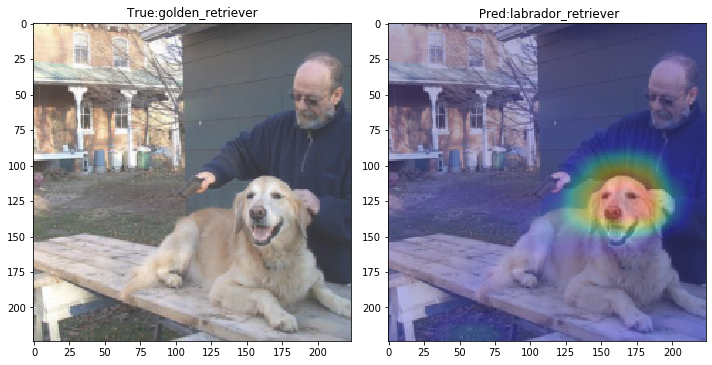

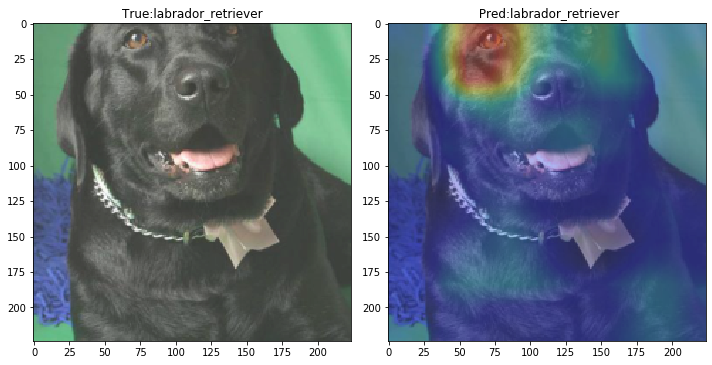

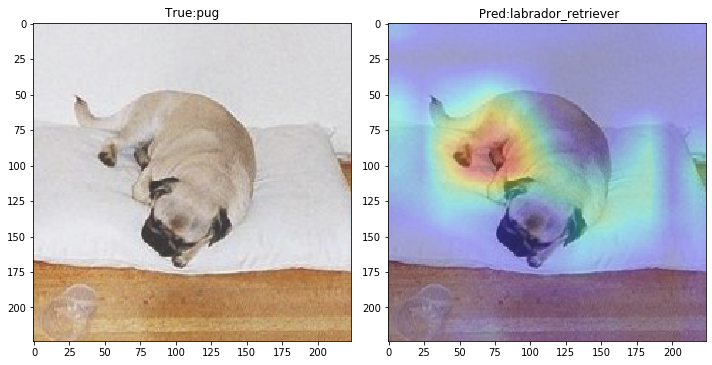

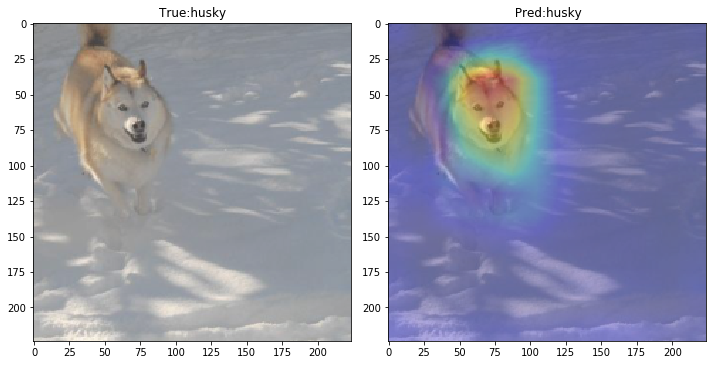

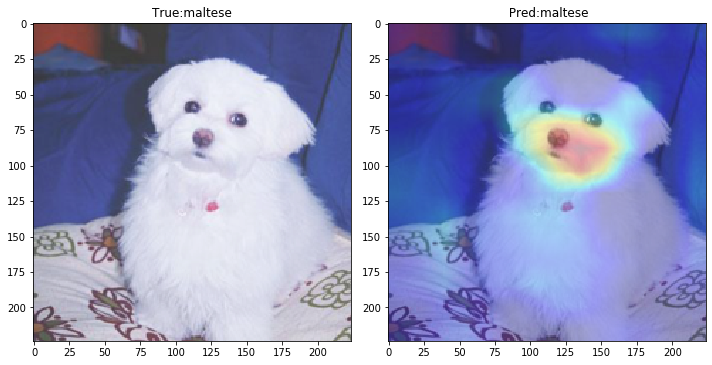

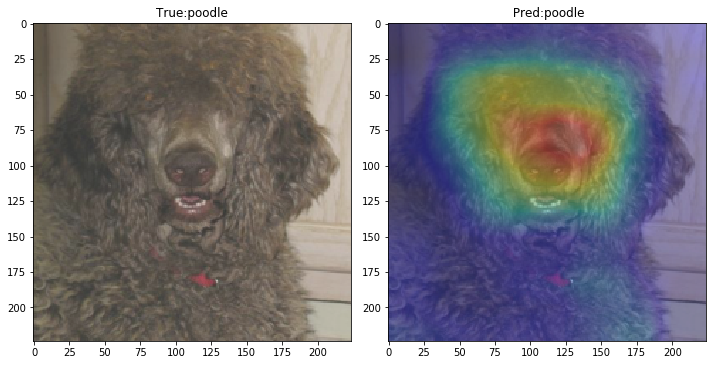

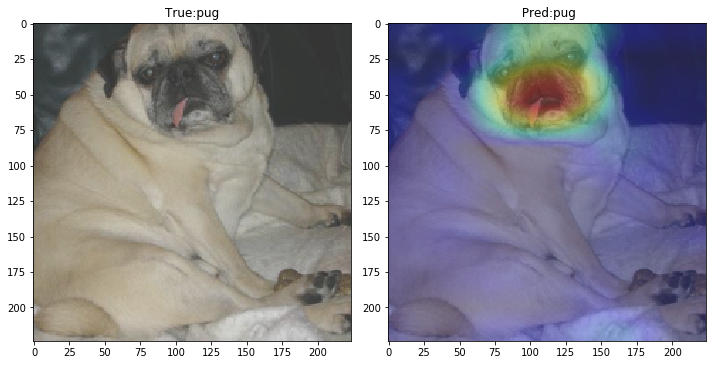

In [ ]:
test_images, test_labels = next(iter(testloader))
test_images, test_labels = test_images.to(device), test_labels.to(device)
# print(test_images.shape, test_labels.shape)

for idx, (t_i, t_l) in enumerate(testloader):
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    GradCam(t_i, t_l)

    if idx > 5:
        break